In [4]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import scipy
import pickle
from source.flux_model import FluxModel



199MB [00:08, 22.2MB/s]                          


In [6]:
from cache import Cache

Cache.set_cache_dir(".cache")

class AtmosphericNuMuFlux(FluxModel):
    
    CACHE_FNAME = "mceq_flux.pickle"
    EMAX = 1E9
    EMIN = 1
    
    def __init__(self):
        self._setup()
        
    def _setup(self):
        if self.CACHE_FNAME in Cache:
            with Cache.open(self.CACHE_FNAME, "rb") as fr:
                self._flux_spline = pickle.load(fr)
        else:
            mceq = MCEqRun(
                # High-energy hadronic interaction model
                interaction_model='SIBYLL23C',

                # cosmic ray flux at the top of the atmosphere
                primary_model = (crf.HillasGaisser2012, 'H3a'),

                # zenith angle
                theta_deg = 0., 
                )

            theta_grid = np.linspace(0, 90, 50)
            numu_fluxes = []
            for theta in theta_grid:
                mceq.set_theta_deg(theta)
                mceq.solve()
                numu_fluxes.append(
                    (mceq.get_solution('numu') +
                     mceq.get_solution('antinumu')))

            emask = (mceq.e_grid < self.EMAX) & (mceq.e_grid > self.EMIN)
            splined_flux = scipy.interpolate.RectBivariateSpline(
                theta_grid,
                np.log10(mceq.e_grid[emask]),
                np.log10(numu_fluxes)[:, emask],
                )
            self._flux_spline = splined_flux
            with Cache.open(self.CACHE_FNAME, "wb") as fr:
                pickle.dump(splined_flux, fr)

    def spectrum(self, energy, dec):
        energy = np.atleast_1d(energy)
        if np.any((energy > self.EMAX) | (energy < self.EMIN)):
            raise ValueError("Energy needs to be in {} < E {}".format(self.EMIN, self.EMAX))
        
        dec = np.atleast_1d(dec)
        zenith = np.pi/2-dec
        zenith[zenith > np.pi/2] = np.pi - zenith[zenith > np.pi/2]
        zenith[zenith < 0] = -zenith[zenith < 0]
        
       
        try:
            result = self._flux_spline(
                np.degrees(zenith), np.log10(energy))
        except ValueError as e:
            print("Error in spline evaluation. Are the evaluation points ordered?")
            raise e
        
        return np.squeeze(result)
    
    def integrated_spectrum(self, energy, zenith):
        pass
    
    


        
        

        

array([ 0.        , 11.59527266, 16.4264214 , 20.15307426, 23.31144568,
       26.10890568, 28.65165903, 31.00271913, 33.2030992 , 35.28126183,
       37.257916  , 39.14868764, 40.96571333, 42.71864451, 44.4153086 ,
       46.06216011, 47.66459812, 49.22719531, 50.75386705, 52.24799869,
       53.71254291, 55.15009542, 56.56295457, 57.95316891, 59.32257553,
       60.67283123, 62.00543827, 63.32176555, 64.62306647, 65.91049389,
       67.18511278, 68.44791111, 69.69980916, 70.94166752, 72.17429413,
       73.3984504 , 74.61485657, 75.82419648, 77.02712185, 78.22425601,
       79.4161974 , 80.60352262, 81.7867893 , 82.96653868, 84.14329809,
       85.31758314, 86.4898999 , 87.66074693, 88.83061719, 90.        ])

In [172]:
atmo_flux = AtmosphericNuMuFlux()

Text(0.5, 0, 'Declination [deg]')

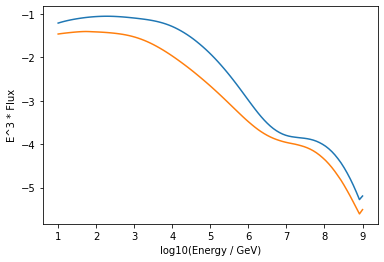

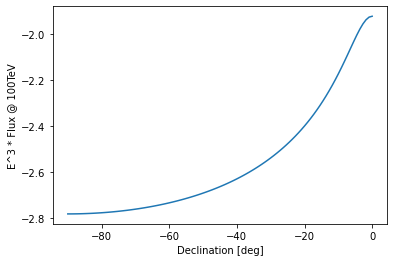

In [135]:
energies = np.linspace(1, 9, 100)
plt.plot(energies, atmo_flux.spectrum(10**energies, 0) + 3*energies)
plt.plot(energies, atmo_flux.spectrum(10**energies, np.pi/4) + 3*energies)
plt.xlabel("log10(Energy / GeV)")
plt.ylabel("E^3 * Flux")
zeniths = np.linspace(-90, 0, 100)
plt.figure()
plt.plot(zeniths, atmo_flux.spectrum(1E5, np.radians(zeniths)) + 3*5)
plt.ylabel("E^3 * Flux @ 100TeV")
plt.xlabel("Declination [deg]")

In [138]:
mceq = MCEqRun(
    # High-energy hadronic interaction model
    interaction_model='SIBYLL23C',

    # cosmic ray flux at the top of the atmosphere
    primary_model = (crf.HillasGaisser2012, 'H3a'),

    # zenith angle
    theta_deg = 0., 
    )

theta = 7
mceq.set_theta_deg(theta)
mceq.solve()
flux = (mceq.get_solution('numu') +
        mceq.get_solution('antinumu'))

e_mask = (mceq.e_grid > 1) & (mceq.e_grid < 1E9)
erange_lim = mceq.e_grid[e_mask]
flux_spline = atmo_flux.spectrum(erange_lim, np.pi/2 -np.radians(theta))


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [147]:
flux_spline = atmo_flux.spectrum(erange_lim, np.pi/2 -np.radians(theta))

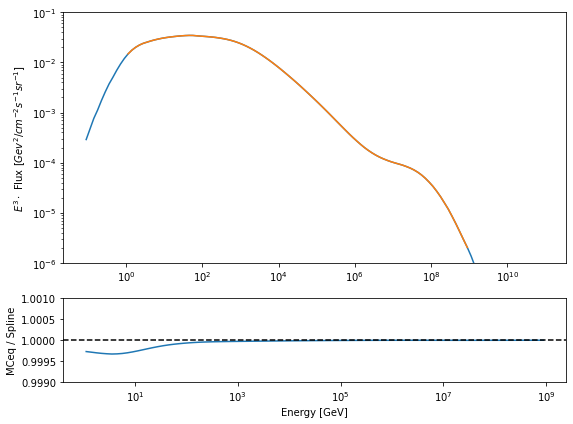

In [170]:
from matplotlib import gridspec as gs

grid = gs.GridSpec(2, 1, height_ratios = [3, 1])
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])

ax1.plot(mceq.e_grid, flux*mceq.e_grid**3)
ax1.plot(erange_lim, 10**flux_spline*erange_lim**3)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.plot(erange_lim, flux[e_mask]/10**flux_spline)

ax2.set_ylim(0.999, 1.001)
ax1.set_ylim(1E-6, 1E-1)
ax2.set_xlabel("Energy [GeV]")
ax1.set_ylabel(r"$E^3 \cdot$ Flux [$ Gev^2/cm^{-2}s^{-1}sr^{-1}]$")
ax2.set_ylabel("MCeq / Spline")
plt.tight_layout()
ax2.axhline(1, ls="--", color="k")


In [ ]:
np.polyfit()